In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [18]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter

from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

### Load route and generate spike versions of headings and optic flow

In [15]:
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


### Rate based CX

In [16]:
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=0,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

### Poisson groups

In [69]:
start_scope()

time_step = 20 # ms

h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')

# Neuron group
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, neuron_params, name='TL2_source_network')

# Add monitors
#STM_TL2, SPM_TL2 = nc.add_monitors(G_TL2, name='TL2_source')

# Connect heading to TL2
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=synapses_params, on_pre=synapses_eqs_ex)

#### Target
TL2_spike_rates = 90 # Hz

# Scale spike rates from rate-based CX in the right range
# transpose since log is neuron_index*time_step but we want the opposite
TL2_stimulus = TimedArray(TL2_spike_rates*cx_log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
# SPM_TL2_IDEAL = SpikeMonitor(P_TL2, name='TL2_target')

Store network 

In [73]:
store('initialised')

In [82]:
def run_simulation_TL2(tauE_, wE_, tauI_, wI_, Group, Synapses, Target,
                       time, dt_, delta, rate_correction): 
    restore('initialised') 

    # set the parameters 
    Group.set_states({'tauE' : tauE_*ms,
                      'tauI' : tauI_*ms})
    print(f'taueE: {tauE_} - tauI {tauI_}')

    Synapses.set_states({'wE' : wE_*nS,
                         'wI' : wI_*nS})
    print(f'wE: {wE_} - wI {wI_}')

    _, model_spike_monitor = nc.add_monitors(Group)
    target_spike_monitor = SpikeMonitor(Target, name='TL2_target_spike_monitor')
    
    run(time)

    gf = metric.compute_gamma_factor(model_spike_monitor, target_spike_monitor, time, 
                                     dt_=dt_, delta=delta, rate_correction=rate_correction)
    
    print(f'Gamma factor: {gf}')

    return gf


In [38]:
tauE_s = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5] # ms
wE_s = [200, 250, 300, 350, 400, 500, 600, 700, 800, 850, 900, 950, 1000] # nS

gamma_factors = np.zeros((len(tauE_s), len(wE_s)))

In [83]:
# Values to optimise
bounds = [[0.1,5],     # tauE [ms]
          [200,1000]] # wE   [nS]
        #   [0.1,5],     # tauI [ms]
        #   [200,1000]] # wI   [nS]


# Other fixed arguments to optimisation function
delta = 1*ms
rate_correction = True

args = [
        1,                       # tauI - useless for this optimisation
        300,                     # wI - useless for this optimisation
        G_TL2,                   # neuron group to optimise
        S_P_HEADING_TL2,         # synapses to optimise
        P_TL2,                   # target population
        T_outbound*time_step*ms, # simulation time
        defaultclock.dt,         # simulation time step
        delta,                   # time window for gamma factor
        rate_correction          # apply rate correction to gamma factor


[7 9]
[[0.37351392 0.19617068 0.9077253  0.7030023  0.91578096 0.71261279
  0.08895795 0.22315249 0.05172215 0.26812548 0.79885966 0.6764763
  0.58558957]
 [0.66236127 0.82630222 0.7367621  0.09313147 0.44115665 0.57587732
  0.80169812 0.73584919 0.96307754 0.16431405 0.44451555 0.72415245
  0.61943664]
 [0.71063679 0.66153916 0.72177275 0.42390918 0.65571516 0.29503857
  0.2222556  0.55161798 0.85914688 0.47557406 0.8918187  0.48858666
  0.69330166]
 [0.24305101 0.3851666  0.89315305 0.25770457 0.86633929 0.26674921
  0.03539591 0.67650649 0.78264451 0.84201602 0.26700151 0.58764471
  0.1222825 ]
 [0.05107988 0.57611467 0.87554541 0.73213473 0.68903546 0.898699
  0.20406758 0.51694749 0.02897258 0.10821614 0.42382382 0.82108151
  0.98133868]
 [0.31583823 0.34330575 0.68641259 0.33216429 0.12127084 0.47050592
  0.38919396 0.83340373 0.7940316  0.80966027 0.94454687 0.16696639
  0.13673328]
 [0.5707309  0.5027695  0.80263733 0.06684873 0.17850183 0.88668311
  0.4225118  0.41610673 0.518

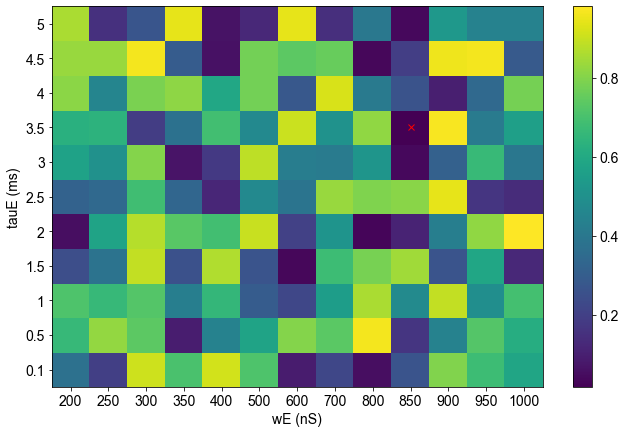

In [73]:
for t, tauE in enumerate(tauE_s):
    for w, wE in enumerate(wE_s):
        #gamma_factors[t,w] = run_simulation_TL2(tauE, wE, 1, 300, G_TL2,
        #                                       S_P_HEADING_TL2, P_TL2, T_outbound*time_step*ms, 
        #                                       defaultclock.dt, delta, rate_correction)
        
        gamma_factors[t,w] = rand()
c = np.argwhere(gamma_factors == np.min(gamma_factors))[0]
print(c)
print(gamma_factors)
print(gamma_factors[c[0],c[1]])
print(tauE_s[c[0]], wE_s[c[1]])

cx_spiking.plotting.plot_gamma_factors(gamma_factors, tauE_s, wE_s)

In [71]:
# Set instruments
instruments = ng_optimiser.set_instrumentation(bounds, args)
optim = ng_optimiser.set_optimiser(instruments, method='SQP', budget=5)

NameError: name 'bounds' is not defined

In [85]:
optim_min, recommendation = ng_optimiser.run_optimiser(optim, run_simulation_CL1, verbosity=2)

Launching 1 jobs with new suggestions
taueE: 2.55 - tauI 1
wE: 600.0 - wI 300
Gamma factor: 5.328725163913077
Candidate(args=(2.55, 600.0, 1, 300, NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='TL2_source_network'), Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses'), PoissonGroup(16, rates='TL2_stimulus(t,i)'), 30. * second, 100. * usecond, 1. * msecond, True), kwargs={}) 5.328725163913077
Updating fitness with value 5.328725163913077
4 remaining budget and 0 running jobs
Current pessimistic best is: Point<x: [0. 0.], mean: 5.328725163913077, count: 1>
Launching 1 jobs with new suggestions
taueE: 2.55 - tauI 1
wE: 600.0 - wI 300
Gamma factor: 5.328555199466255
Candidate(args=(2.55, 600.0, 1, 300, NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='TL2_source_network'), Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, nam

In [86]:
candidate = optim_min.provide_recommendation()

In [87]:
print(candidate.args)

(2.55, 600.0, 1, 300, NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='TL2_source_network'), Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses'), PoissonGroup(16, rates='TL2_stimulus(t,i)'), 30. * second, 100. * usecond, 1. * msecond, True)


### Test

In [52]:
start_scope()

time_step = 20 # ms

In [53]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')

In [54]:
params_CL1 = neuron_params
synapses_CL1 = synapses_params

params_CL1['tauE'] = candidate.args[0] * ms
synapses_CL1['wE'] = candidate.args[1] * nS

# params_CL1['tauI'] = 1 * ms
# synapses_CL1['wI'] = 300 * nS

print(params_CL1)
print(synapses_CL1)

{'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS', 'gI': '(randn() * 12 + 20) * 10.*nS', 'tauE': 2.16315764 * msecond, 'tauI': 0.65653371 * msecond}
{'wE': 0.37402703 * usiemens, 'wI': 0.7607643 * usiemens}


In [55]:
# Neuron group
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, params_TL2, name='TL2_test')

# Add monitors
STM_TL2, SPM_TL2 = nc.add_monitors(G_TL2, name='TL2_test')

# Connect heading to TL2
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, params=synapses_TL2, model=synapses_model, on_pre=synapses_eqs_ex)

In [56]:
%%time
run(T_outbound*time_step*ms)

CPU times: user 45.9 s, sys: 878 ms, total: 46.8 s
Wall time: 1min 4s


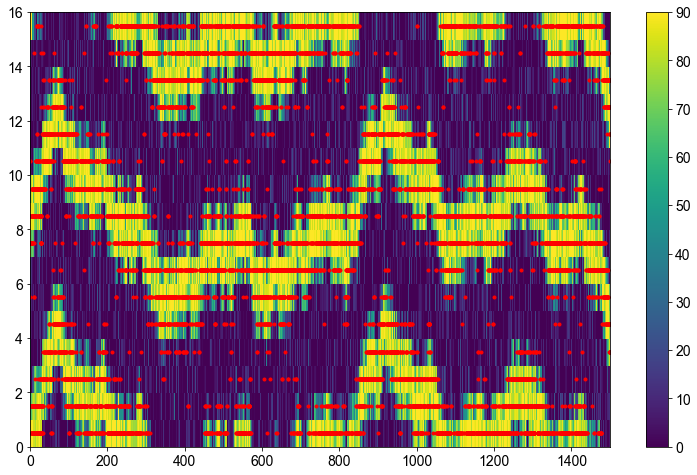

In [57]:
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tl2, TL2_spike_rates, SPM_TL2, time_step, figsize=(13,8))

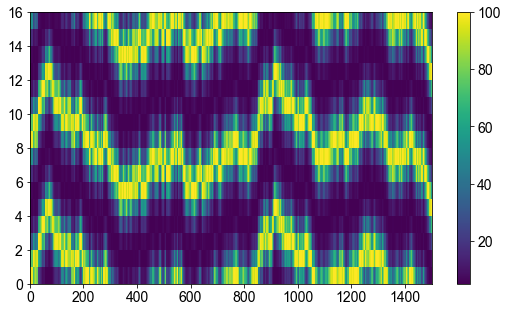

In [32]:
plt.figure(figsize=(9,5))
plt.pcolormesh(headings.T)
plt.colorbar()
plt.show()

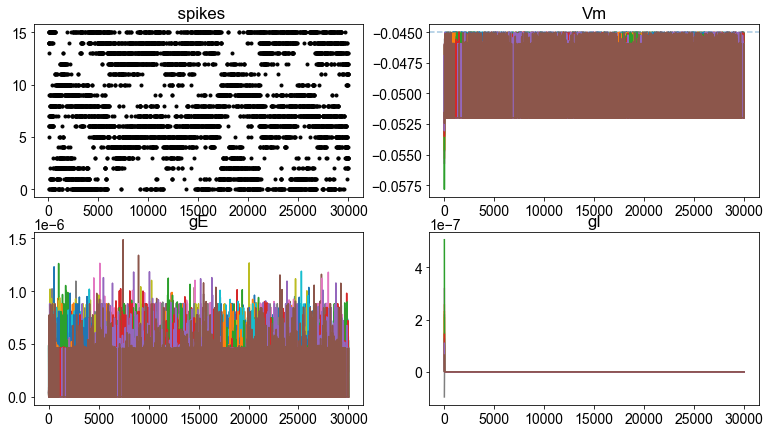

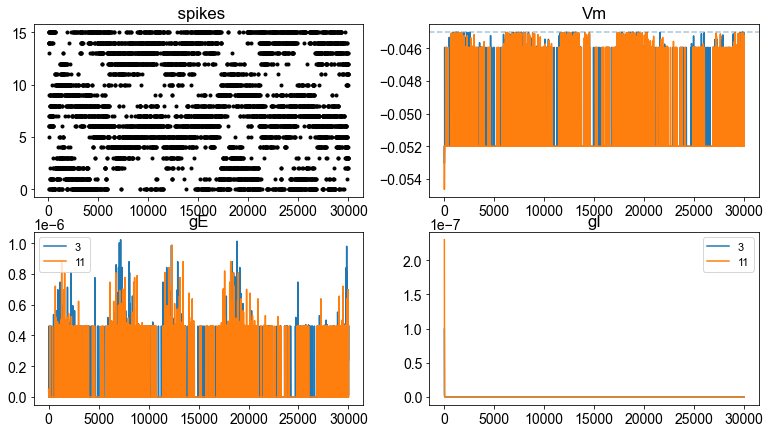

In [24]:
cx_spiking.plotting.plot_stuff(STM_TL2, SPM_TL2, observation_list=range(16), figsize=(13,7))
cx_spiking.plotting.plot_stuff(STM_TL2, SPM_TL2, observation_list=[3, 11], figsize=(13,7))